# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Load Dependencies

In [475]:
from sklearn import model_selection, pipeline, ensemble, metrics, tree
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, info_plots
import matplotlib.pyplot as plt
import category_encoders as ce
import graphviz as gv
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import json
import eli5

#### Download Data

In [2]:
TRAIN_URL = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
TEST_URL  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

In [136]:
train = pd.read_csv(TRAIN_URL)
test  = pd.read_csv(TEST_URL)

In [137]:
assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

In [29]:
labels = pd.DataFrame({ 'train': train.Fail.value_counts()/train.Fail.size, 'test': test.Fail.value_counts()/test.Fail.size }).T
labels['size'] = pd.Series([train.Fail.size, test.Fail.size], index=['train', 'test'])
labels

,0,1,size
test,0.741419,0.258581,17306
train,0.741390,0.258610,51916


In [250]:
clean = train.copy(deep=True).drop(columns='Location')
clean['Violations'] = train['Violations'].fillna('Unknown').astype('category').cat.codes
clean['Inspection Type'] = train['Inspection Type'].fillna('Unknown').astype('category').cat.codes
clean['Facility Type'] = train['Facility Type'].fillna('Unknown').astype('category').cat.codes
clean['Inspection Date'] = pd.to_datetime(train['Inspection Date']).dt.strftime("%Y%m%d").astype(np.int)
clean['Risk'] = train['Risk'].fillna('Risk -1 (Unknown)').astype('category').cat.codes
clean['AKA Name'] = train['AKA Name'].fillna('Unknown').astype('category').cat.codes
clean['Address'] = train['Address'].fillna('Unknown').astype('category').cat.codes
clean['State'] = train['State'].fillna('Unknown').astype('category').cat.codes
clean['City'] = train['City'].fillna('Unknown').astype('category').cat.codes
clean['Longitude'] = train['Longitude'].fillna(train['Longitude'].mean())
clean['Latitude'] = train['Latitude'].fillna(train['Latitude'].mean())
clean['DBA Name'] = train['DBA Name'].astype('category').cat.codes
clean['Zip'] = train['Zip'].fillna(train['Zip'].mode()[0])
clean['License #'] = train['License #'].fillna(-1)

### Data Leakage

It seems likely that the leaky column in question is the `Violations` feature. To receive<br>
a list of violations is to fail your inspection, hence any rows without a `NaN` in that<br>
column will be predicted with near perfect accuracy to have failed their inspection.<br>
This is reinforced below where a decision tree is fit on the data set with and without<br>
the data leakage, yielding drastically different results.

#### With Data Leakage

In [521]:
X = clean.drop(columns="Fail")
y = clean.Fail

In [522]:
leaky = tree.DecisionTreeClassifier(max_depth=3)

In [523]:
model_selection.cross_val_score(leaky, X, y, cv=5, scoring='roc_auc', n_jobs=-1)

array([0.97669838, 0.97680173, 0.97421793, 0.97213143, 0.97578802])

In [524]:
model_selection.cross_val_score(leaky, X, y, cv=5, scoring='f1', n_jobs=-1)

array([0.92274762, 0.92839024, 0.92277842, 0.92049228, 0.92149242])

In [525]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [526]:
leaky.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [527]:
dots = tree.export_graphviz(
    leaky, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=['Pass', 'Fail'],
    filled=True, 
    impurity=False,
    proportion=True
)

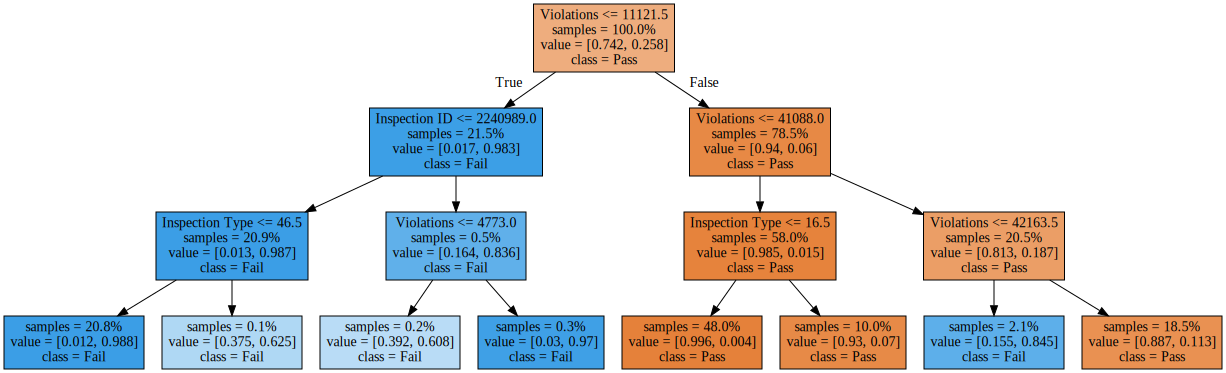

In [528]:
gv.Source(dots)

In [529]:
eli5.show_weights(PermutationImportance(leaky, scoring='roc_auc', n_iter=10, cv='prefit').fit(X_train, y_train), feature_names=X_train.columns.tolist()) 

Weight,Feature
0.4646 ± 0.0054,Violations
0.0086 ± 0.0006,Inspection Type
0.0005 ± 0.0000,Inspection ID
0 ± 0.0000,Longitude
0 ± 0.0000,Latitude
0 ± 0.0000,Inspection Date
0 ± 0.0000,Zip
0 ± 0.0000,State
0 ± 0.0000,City
0 ± 0.0000,Address


#### Without Data Leakage

In [510]:
X = clean.drop(columns=["Fail", "Violations"])
y = clean.Fail

In [511]:
airtight = tree.DecisionTreeClassifier(max_depth=3)

In [512]:
model_selection.cross_val_score(airtight, X, y, cv=5, scoring='roc_auc', n_jobs=-1)

array([0.63522962, 0.64056407, 0.63227011, 0.64036883, 0.64205228])

In [513]:
model_selection.cross_val_score(airtight, X, y, cv=5, scoring='f1', n_jobs=-1)

array([0.08127822, 0.05001786, 0.08623663, 0.08617718, 0.09353508])

In [514]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [515]:
airtight.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [516]:
dots = tree.export_graphviz(
    airtight, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=['Pass', 'Fail'],
    filled=True, 
    impurity=False,
    proportion=True
)

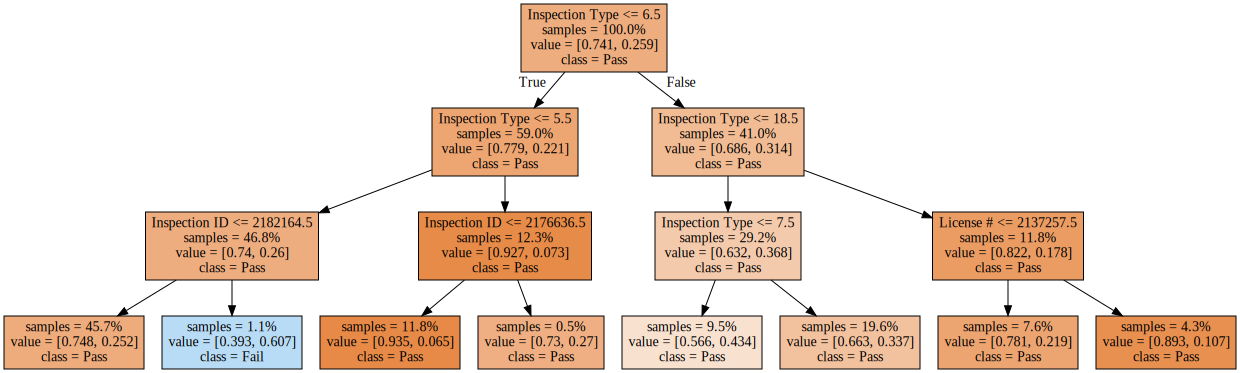

In [517]:
gv.Source(dots)

In [519]:
eli5.show_weights(PermutationImportance(airtight, scoring='roc_auc', n_iter=10, cv='prefit').fit(X_train, y_train), feature_names=X_train.columns.tolist()) 

Weight,Feature
0.1299 ± 0.0051,Inspection Type
0.0129 ± 0.0014,Inspection ID
0.0009 ± 0.0002,License #
0 ± 0.0000,Longitude
0 ± 0.0000,Latitude
0 ± 0.0000,Inspection Date
0 ± 0.0000,Zip
0 ± 0.0000,State
0 ± 0.0000,City
0 ± 0.0000,Address


### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [285]:
X = clean.drop(columns=["Fail", "Violations"])
y = clean.Fail

In [286]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

#### Random Forests

In [304]:
forest = ensemble.RandomForestClassifier(
    criterion="entropy",
    n_estimators=100,
    max_depth=30,
    min_samples_split=50,
    min_samples_leaf=50, 
    class_weight={0: 1, 1: 3 },
    n_jobs=-1
)

In [480]:
roc_auc = model_selection.cross_validate(forest, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
f1 = model_selection.cross_validate(forest, X, y, cv=5, scoring='f1', n_jobs=-1)

In [481]:
f1['test_score'], roc_auc['test_score']

(array([0.49927431, 0.48967807, 0.5077615 , 0.50373189, 0.50714078]),
 array([0.71884911, 0.71377784, 0.7214981 , 0.72426273, 0.72417281]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


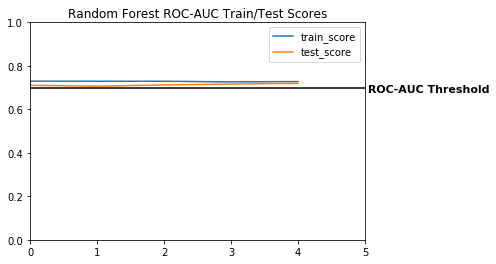

In [367]:
data = pd.DataFrame(roc_auc)

plt.title("Random Forest ROC-AUC Train/Test Scores")
plt.xlim(0, 5)
plt.ylim(0, 1)

plt.axhline(0.7, c='black')
plt.annotate('ROC-AUC Threshold', xy=(5, 0.68), xytext=(5.05, 0.68), fontsize=11, fontweight='bold')

plt.plot(data.index, data.train_score)
plt.plot(data.index, data.test_score)

plt.legend();

#### Gradient Boosting

In [290]:
gbc = ensemble.GradientBoostingClassifier()

In [482]:
roc_auc = model_selection.cross_validate(gbc, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
f1 = model_selection.cross_validate(gbc, X, y, cv=5, scoring='f1', n_jobs=-1)

In [483]:
f1['test_score'], roc_auc['test_score']

(array([0.13702329, 0.17018513, 0.17754905, 0.17906602, 0.18199482]),
 array([0.71039983, 0.70640646, 0.71220284, 0.71631283, 0.71954889]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


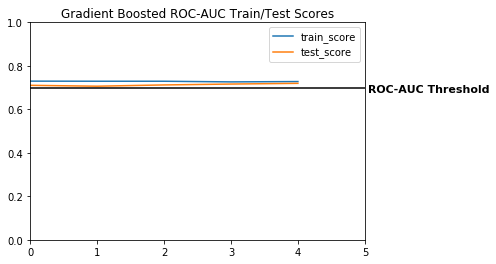

In [369]:
data = pd.DataFrame(roc_auc)

plt.title("Gradient Boosted ROC-AUC Train/Test Scores")
plt.xlim(0, 5)
plt.ylim(0, 1)

plt.axhline(0.7, c='black')
plt.annotate('ROC-AUC Threshold', xy=(5, 0.68), xytext=(5.05, 0.68), fontsize=11, fontweight='bold')

plt.plot(data.index, data.train_score)
plt.plot(data.index, data.test_score)

plt.legend();

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [461]:
gbc.fit(X_train, y_train)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
            criterion='entropy', max_depth=30, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

#### Partial Depedence Plot

In [496]:
isolate = pdp.pdp_isolate(forest, X, X.columns.values, 'Inspection ID')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fda46154a58>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fda4623db00>})

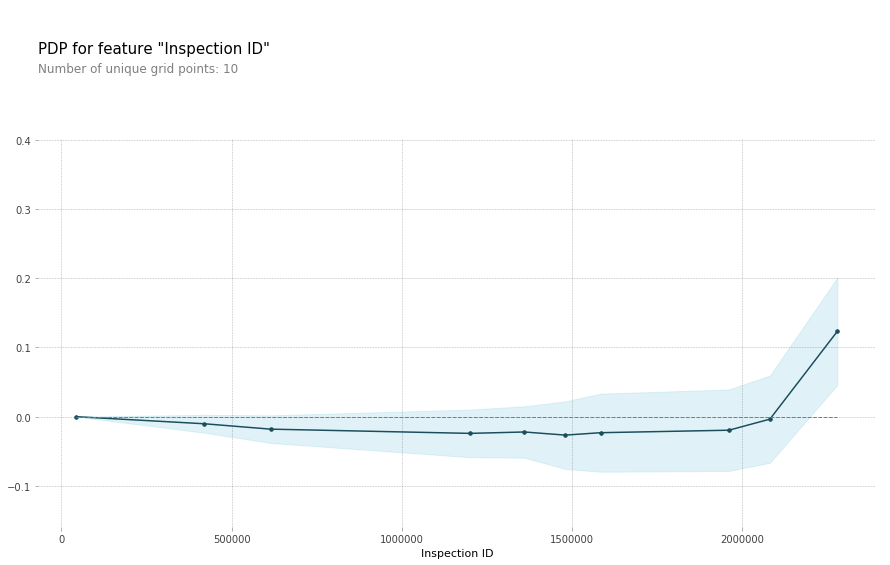

In [497]:
pdp.pdp_plot(isolate, 'Inspection ID')

#### Premutation Importance

In [462]:
gradient_permuter = PermutationImportance(gbc, scoring='roc_auc', n_iter=10, cv='prefit')
forest_permuter = PermutationImportance(forest, scoring='roc_auc', n_iter=10, cv='prefit')

In [463]:
gradient_permuter.fit(X_train, y_train)
forest_permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
            criterion='entropy', max_depth=30, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=50,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
           n_iter=10, random_state=None, refit=True, scoring='roc_auc')

In [467]:
eli5.show_weights(gradient_permuter, feature_names=X_train.columns.tolist())

Weight,Feature
0.1621 ± 0.0035,Inspection Type
0.0423 ± 0.0015,Inspection ID
0.0142 ± 0.0016,Zip
0.0129 ± 0.0012,Inspection Date
0.0124 ± 0.0011,Facility Type
0.0097 ± 0.0008,Longitude
0.0088 ± 0.0007,Latitude
0.0073 ± 0.0006,License #
0.0029 ± 0.0004,DBA Name
0.0015 ± 0.0003,Risk


In [468]:
eli5.show_weights(forest_permuter, feature_names=X_train.columns.tolist())

Weight,Feature
0.1751 ± 0.0039,Inspection Type
0.0646 ± 0.0031,License #
0.0471 ± 0.0016,Inspection ID
0.0404 ± 0.0012,Inspection Date
0.0354 ± 0.0012,Longitude
0.0346 ± 0.0016,Latitude
0.0280 ± 0.0011,Zip
0.0184 ± 0.0008,DBA Name
0.0179 ± 0.0005,Address
0.0172 ± 0.0005,AKA Name
